In [1]:
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon,Rectangle
from PIL import Image
from io import BytesIO
import time
import numpy as np
from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models
%matplotlib inline

In [2]:
import settings
assert settings.vision_subscription_key 
assert settings.vision_base_url 
assert settings.customvision_prediction_key
assert settings.customvision_projectid
assert settings.customvision_iterationid

In [3]:
def displayrecognizeTextresult(imagepath,analysis,ax=None,x_start=0,y_start=0):
    
    # Display the image  
    if(ax==None):
        # Display the image and overlay it with the extracted text.
        plt.figure(figsize=(15, 15))
        image = Image.open(imagepath)
        ax = plt.imshow(image, alpha=0.5)
    
    polygons=[]
    
    if ("recognitionResult" in analysis):
        # Extract the recognized text, with bounding boxes.
        polygons = [(line["boundingBox"], line["text"])
            for line in analysis["recognitionResult"]["lines"]]

        
    #overlay the image with the extracted text
    for polygon in polygons:
        vertices = [(polygon[0][i]+x_start, polygon[0][i+1]+y_start)
            for i in range(0, len(polygon[0]), 2)]
        text     = polygon[1]
        patch    = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
        ax.axes.add_patch(patch)
        plt.text(vertices[0][0], vertices[0][1], text, fontsize=10, va="top")
    _ = plt.axis("off")

In [4]:
def recognizeText(imagepath,mode='Handwritten'):
    
    
    text_recognition_url = settings.vision_base_url + "recognizeText"


    img_data=[]
    with open(imagepath, 'rb') as f:
        img_data = f.read()

    headers = {'Ocp-Apim-Subscription-Key': settings.vision_subscription_key   ,
              'Content-Type':'application/octet-stream'}

    params  = {'mode': mode}

    response = requests.post(
        text_recognition_url, headers=headers, params=params, data=img_data)

    response.raise_for_status()

    # Extracting handwritten text requires two API calls: One call to submit the
    # image for processing, the other to retrieve the text found in the image.

    # Holds the URI used to retrieve the recognized text.
    operation_url = response.headers["Operation-Location"]

    # The recognized text isn't immediately available, so poll to wait for completion.
    analysis = {}
    poll = True
    while (poll):
        response_final = requests.get(
            response.headers["Operation-Location"], headers=headers)
        analysis = response_final.json()
        time.sleep(1)
        if ("recognitionResult" in analysis):
            poll= False 
        if ("status" in analysis and analysis['status'] == 'Failed'):
            poll= False

    
    return analysis

In [5]:
def displayocrresult(imagepath,analysis,ax=None,x_start=0,y_start=0):
    
    # Display the image  
    if(ax==None):
        # Display the image and overlay it with the extracted text.
        plt.figure(figsize=(15, 15))
        image = Image.open(imagepath)
        ax = plt.imshow(image, alpha=0.5)
        
    # Extract the word bounding boxes and text.
    line_infos = [region["lines"] for region in analysis["regions"]]
    word_infos = []
    for line in line_infos:
        for word_metadata in line:
            for word_info in word_metadata["words"]:
                word_infos.append(word_info)
    
    
    for word in word_infos:
        bbox = [int(num) for num in word["boundingBox"].split(",")]
        text = word["text"]
        origin = (bbox[0], bbox[1])
        patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=2, color='y')
        ax.axes.add_patch(patch)
        plt.text(origin[0], origin[1], text, fontsize=10, weight="bold", va="top")
    plt.axis("off")

In [6]:
def ocr(imagepath):

    ocr_url = settings.vision_base_url + "ocr"

    img_data=[]
    with open(imagepath, 'rb') as f:
        img_data = f.read()

    headers = {'Ocp-Apim-Subscription-Key': settings.vision_subscription_key,
               'Content-Type':'application/octet-stream'}
    params  = {'language': 'unk', 'detectOrientation': 'true'}
    
    response = requests.post(ocr_url, headers=headers, params=params, data=img_data)
    response.raise_for_status()

    analysis = response.json()

    return analysis

In [7]:
def findsigns(imagepath,sign_recognizer):
    
    predictor = prediction_endpoint.PredictionEndpoint(settings.customvision_prediction_key)
    
    with open(imagepath, mode="rb") as image_data:
        results = predictor.predict_image(settings.customvision_projectid, image_data, settings.customvision_iterationid)

    image = Image.open(imagepath)
    np_image = np.array(image)

    signs =[]
    arrows=[]
    cropadjustment=10
    arrowadjustment=20
    index=0
    # Display the results.
    for prediction in results.predictions:
        #print ("\t" + prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100), prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height)

        if (( prediction.tag_name == 'ParkingSign' and prediction.probability>0.3) or
            ('Arrow' in prediction.tag_name and prediction.probability>=0.05)): #

            h=np_image.shape[0]
            w=np_image.shape[1]
            x = int(prediction.bounding_box.left * w)
            y = int((prediction.bounding_box.top )* h)
            width = int(prediction.bounding_box.width * w)
            height = int(prediction.bounding_box.height * h)
            if(prediction.tag_name == 'ParkingSign'):
                #box=(x-cropadjustment, y-cropadjustment, x+width+cropadjustment, y+height+cropadjustment)
                #area = image.crop(box) #.convert('L')
                #filename='./temp/'+ str(index) +'.jpg'
                #area.save(filename)
                signs.append({'probability':prediction.probability,'sign_coordinates':[x, y, x+width, y+height],'sign_size':[width,height]})
            if('Arrow' in prediction.tag_name):
                arrows.append({'probability':prediction.probability,'arrow':prediction.tag_name.replace('Arrow', ''),'arrow_coordinates':[x, y, x+width, y+height],'arrow_size':[width,height]})

            index= index+1
    
    
    texts=[]
    
    if(sign_recognizer=='recognizeText'):
        analysis=recognizeText(imagepath,'Printed')
        
        if ("recognitionResult" in analysis):
            # Extract the recognized text, with bounding boxes.
            polygons = [(line["boundingBox"], line["text"]) for line in analysis["recognitionResult"]["lines"]]

            #overlay the image with the extracted text
            for polygon in polygons:
                vertices = [(polygon[0][i], polygon[0][i+1]) for i in range(0, len(polygon[0]), 2)]
                text={"x":vertices[0][0],"y":vertices[0][1],"text":polygon[1],"boundingtype":"polygon","coordinates":vertices}
                texts.append(text)
               
  

    if(sign_recognizer=='ocr'):
        analysis=ocr(imagepath)
        if ("regions" in analysis):
            # Extract the word bounding boxes and text.
            line_infos = [region["lines"] for region in analysis["regions"]]
            word_infos = []
            for line in line_infos:
                for word_metadata in line:
                    for word_info in word_metadata["words"]:
                        word_infos.append(word_info)


            for word in word_infos:
                bbox = [int(num) for num in word["boundingBox"].split(",")]
                text = word["text"]
                texts.append({"x":bbox[0],"y":bbox[1],"text":word["text"],"boundingtype":"rectangle","coordinates":[bbox[0],bbox[1],bbox[2],bbox[3]]})
               

            

    for sign in signs:
        
        sign_x1=sign['sign_coordinates'][0]
        sign_y1=sign['sign_coordinates'][1]
        sign_x2=sign['sign_coordinates'][2]
        sign_y2=sign['sign_coordinates'][3]
        sign_w=sign['sign_size'][0]
        sign_h=sign['sign_size'][1]
        
        sign["texts"]=[]
        for text in texts: 
            
            if(text["x"]>=sign_x1  and text["x"]<sign_x2 and text["y"]>=sign_y1 and text["y"]<sign_y2):
                sign["texts"].append(text)
           
        for arrow in arrows:
            
            arrow_x1=arrow['arrow_coordinates'][0]
            arrow_y1=arrow['arrow_coordinates'][1]
            arrow_x2=arrow['arrow_coordinates'][2]
            arrow_y2=arrow['arrow_coordinates'][3]
            arrow_w=arrow['arrow_size'][0]
            arrow_h=arrow['arrow_size'][1]
          
            if ((arrow_x1>=sign_x1 or abs(arrow_x1-sign_x1)<=arrowadjustment) and
                    (arrow_x2<=sign_x2 or abs(arrow_x2-sign_x2)<=arrowadjustment) and 
                    (arrow_y1>=sign_y1 or abs(arrow_y1-sign_y1)<=arrowadjustment) and 
                    (arrow_y2<=sign_y2 or abs(arrow_y2-sign_y2)<=arrowadjustment)) :
                    
                    if("arrow" in sign):
                        
                        if(sign["arrow"]["probability"]<arrow["probability"]):
                            sign["arrow"]= arrow
                    else:
                        sign["arrow"]= arrow
                    
            
    return signs
            


In [8]:
def displysigns(imagepath,signs):
    
    
    plt.figure(figsize=(15, 15))

    image = Image.open(imagepath)
    np_image = np.array(image)
    ax = plt.imshow(image, alpha=0.5)
    
    for sign in signs:

        sign_x1=sign['sign_coordinates'][0]
        sign_y1=sign['sign_coordinates'][1]
        sign_x2=sign['sign_coordinates'][2]
        sign_y2=sign['sign_coordinates'][3]
        sign_w=sign['sign_size'][0]
        sign_h=sign['sign_size'][1]
        patch_sign=Rectangle((sign_x1,sign_y1), sign_w, sign_h, fill=False, linewidth=2, color='r')
        ax.axes.add_patch(patch_sign)
        
        for text in sign["texts"]: 
            plt.text(text["x"], text["y"], text["text"], fontsize=10, weight="bold", va="center",ha="left")
            if(text["boundingtype"]=="rectangle"):
                patch  = Rectangle((text["coordinates"][0],text["coordinates"][1]), text["coordinates"][2], text["coordinates"][3], fill=False, linewidth=2, color='y')
                ax.axes.add_patch(patch)
            else:
                patch    = Polygon(text["coordinates"], closed=True, fill=False, linewidth=2, color='y')
                ax.axes.add_patch(patch)
               
                    
        if('arrow' in sign):
            arrow_x1=sign['arrow']['arrow_coordinates'][0]
            arrow_y1=sign['arrow']['arrow_coordinates'][1]
            arrow_x2=sign['arrow']['arrow_coordinates'][2]
            arrow_y2=sign['arrow']['arrow_coordinates'][3]
            arrow_w=sign['arrow']['arrow_size'][0]
            arrow_h=sign['arrow']['arrow_size'][1]
            patch_arrow=Rectangle((arrow_x1,arrow_y1), arrow_w, arrow_h, fill=False, linewidth=2, color='r')
            ax.axes.add_patch(patch_arrow)
        
        print(sign["texts"])
            
            
        

        

        




    _ = plt.axis("off")
    plt.show()

./Parking signs/32.jpg


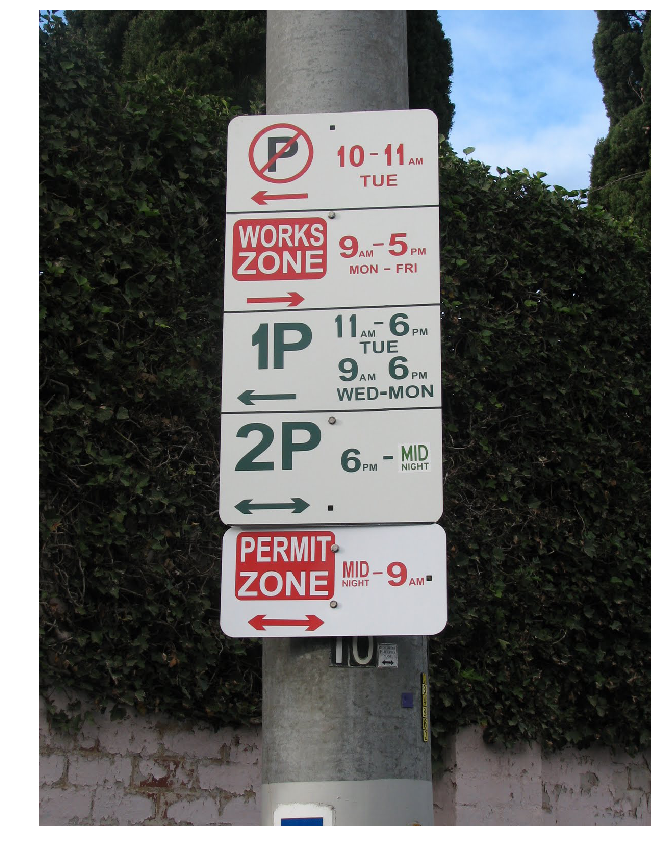

In [9]:
imagepath='./Parking signs/32.jpg' #14-20-32-39
print(imagepath)
image = Image.open(imagepath)
plt.figure(figsize=(15, 15))
image = Image.open(imagepath)
ax = plt.imshow(image)
_ = plt.axis("off")
plt.show()

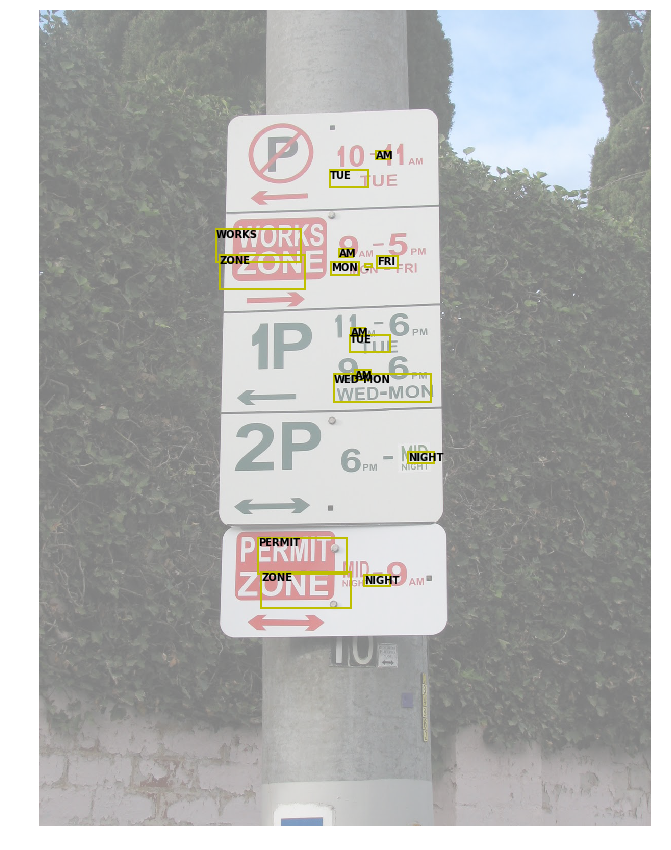

In [10]:
ocrresult=ocr(imagepath)
#print(ocrresult)
displayocrresult(imagepath,ocrresult)

{'recognitionResult': {'lines': [{'boundingBox': [576, 252, 752, 254, 755, 309, 576, 314], 'words': [{'boundingBox': [576, 252, 647, 253, 646, 315, 576, 314], 'text': '10'}, {'boundingBox': [638, 253, 729, 254, 729, 316, 638, 315], 'text': '-11'}, {'boundingBox': [713, 254, 762, 254, 762, 316, 712, 316], 'text': 'AM'}], 'text': '10 -11 AM'}, {'boundingBox': [625, 320, 706, 319, 706, 347, 626, 349], 'words': [{'boundingBox': [632, 322, 697, 320, 698, 349, 634, 349], 'text': 'TUE'}], 'text': 'TUE'}, {'boundingBox': [391, 417, 557, 414, 558, 467, 392, 470], 'words': [{'boundingBox': [389, 418, 565, 416, 565, 469, 391, 471], 'text': 'WORKS'}], 'text': 'WORKS'}, {'boundingBox': [389, 471, 562, 468, 563, 519, 391, 523], 'words': [{'boundingBox': [388, 472, 554, 471, 554, 520, 389, 524], 'text': 'ZONE'}], 'text': 'ZONE'}, {'boundingBox': [575, 432, 767, 429, 769, 491, 577, 495], 'words': [{'boundingBox': [584, 436, 685, 432, 687, 489, 586, 495], 'text': '9AM-'}, {'boundingBox': [681, 432, 720

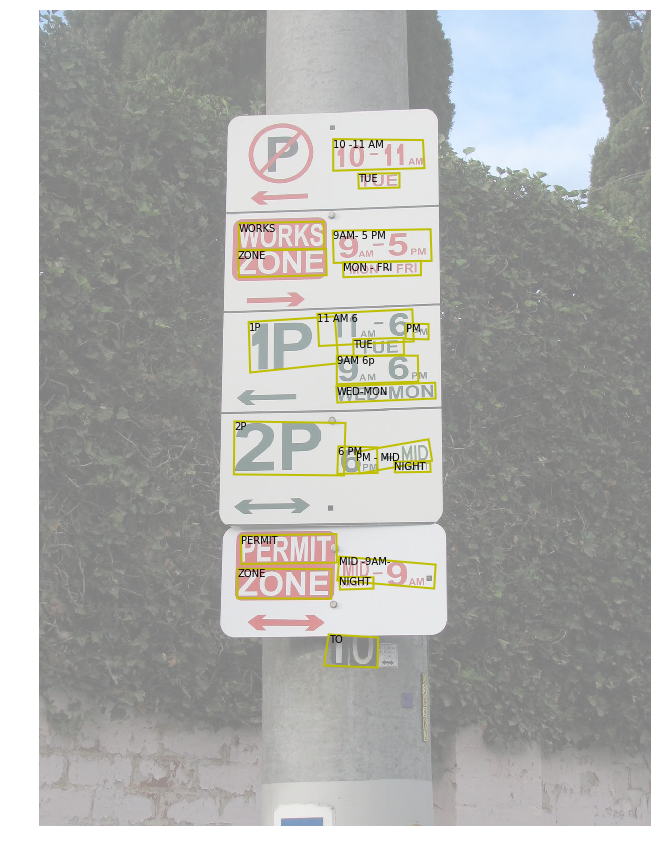

In [11]:
recognizeTextresult=recognizeText(imagepath,'Printed')
print(recognizeTextresult)
displayrecognizeTextresult(imagepath,recognizeTextresult)

[{'coordinates': [(410, 611), (579, 600), (586, 692), (413, 710)], 'boundingtype': 'polygon', 'y': 611, 'x': 410, 'text': '1P'}, {'coordinates': [(545, 595), (731, 586), (734, 649), (548, 658)], 'boundingtype': 'polygon', 'y': 595, 'x': 545, 'text': '11 AM 6'}, {'coordinates': [(615, 645), (714, 642), (715, 675), (616, 679)], 'boundingtype': 'polygon', 'y': 645, 'x': 615, 'text': 'TUE'}, {'coordinates': [(719, 614), (763, 615), (763, 645), (718, 644)], 'boundingtype': 'polygon', 'y': 614, 'x': 719, 'text': 'PM'}, {'coordinates': [(583, 677), (742, 677), (743, 728), (583, 733)], 'boundingtype': 'polygon', 'y': 677, 'x': 583, 'text': '9AM 6p'}, {'coordinates': [(582, 737), (776, 730), (777, 761), (584, 769)], 'boundingtype': 'polygon', 'y': 737, 'x': 582, 'text': 'WED-MON'}]
[{'coordinates': [(382, 806), (600, 809), (597, 912), (381, 910)], 'boundingtype': 'polygon', 'y': 806, 'x': 382, 'text': '2P'}, {'coordinates': [(620, 866), (763, 841), (770, 883), (628, 908)], 'boundingtype': 'poly

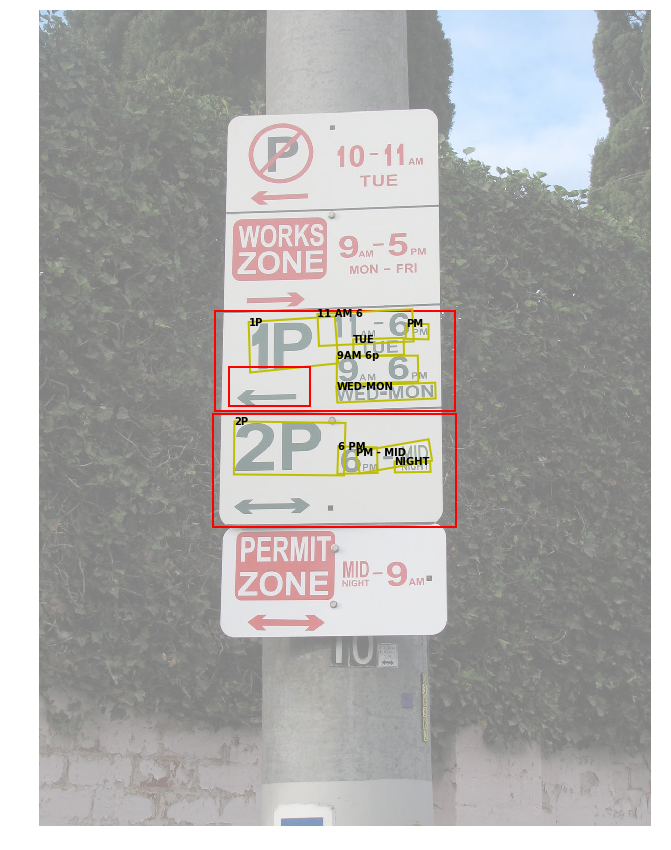

In [12]:
signs=findsigns(imagepath,'recognizeText')
#print(signs)
displysigns(imagepath,signs)